

# **Классификация паролей пользователей по стойкости к взлому**

---

На основе: “Password Strength Classifier Dataset” - https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
import seaborn as sns

## Загрузка датасета

In [3]:
df = pd.read_csv('data_2.csv', on_bad_lines='skip')

In [ ]:
df

,password,strength,length,lower_freq,upper_freq,digit_freq,special_freq,type_breaks
0,intel1,0,6,0.833333,0.0000,0.166667,0.000000,1
1,lsdlsd1,0,7,0.857143,0.0000,0.142857,0.000000,1
2,olmaz.,0,6,0.833333,0.0000,0.000000,0.166667,1
3,ok>bdk,0,6,0.833333,0.0000,0.000000,0.166667,2
4,d04m11,0,6,0.333333,0.0000,0.666667,0.000000,3
...,...,...,...,...,...,...,...,...
255970,juanpaganini588@gmail.com,2,25,0.800000,0.0000,0.120000,0.080000,5
255971,tYAam8zg3Mg2AZ7a,2,16,0.437500,0.3125,0.250000,0.000000,8
255972,weslley.06888524,2,16,0.437500,0.0000,0.500000,0.062500,2
255973,sakaryal&#305;,2,14,0.571429,0.0000,0.214286,0.214286,3


In [4]:
pd.options.mode.chained_assignment = None

## Анализ

### Определение факторов

In [ ]:
df['length'] = [len(i) for i in df['password']]

df['lower_freq'] = [len([j for j in i if j.islower()]) / len(i) for i in df['password']]

df['upper_freq'] = [len([j for j in i if j.isupper()]) / len(i) for i in df['password']]

df['digit_freq'] = [len([j for j in i if j.isdigit()]) / len(i) for i in df['password']]

df['special_freq'] = [len([j for j in i if not j.isdigit() and not j.isalpha()]) / len(i) for i in df['password']]

df

,password,strength,length,lower_freq,upper_freq,digit_freq,special_freq
0,kzde5577,1,8,0.500000,0.0,0.500000,0.0
1,kino3434,1,8,0.500000,0.0,0.500000,0.0
2,visi7k1yr,1,9,0.777778,0.0,0.222222,0.0
3,megzy123,1,8,0.625000,0.0,0.375000,0.0
4,lamborghin1,1,11,0.909091,0.0,0.090909,0.0
...,...,...,...,...,...,...,...
669635,10redtux10,1,10,0.600000,0.0,0.400000,0.0
669636,infrared1,1,9,0.888889,0.0,0.111111,0.0
669637,184520socram,1,12,0.500000,0.0,0.500000,0.0
669638,marken22a,1,9,0.777778,0.0,0.222222,0.0


In [ ]:
df['identical_freq'] = [(re.match('([a-z\\d])\\1\\1\\1\\1\\1\\1\\1+', i) is not None) for i in df['password']]

In [ ]:
df[df.columns[0::7]]

,password,identical_freq
0,kzde5577,False
1,kino3434,False
2,visi7k1yr,False
3,megzy123,False
4,lamborghin1,False
...,...,...
669635,10redtux10,False
669636,infrared1,False
669637,184520socram,False
669638,marken22a,False


In [ ]:
chi2(df['identical_freq'].values.reshape(-1, 1), df['strength'].values)

(array([5.9143319]), array([0.05196598]))

In [ ]:
df['type_breaks'] = [len(re.findall('[aA-zZ]+',i)) + len(re.findall('[\W]+', i)) + len(re.findall('[0-9]+', i)) - 1 for i in df['password']]

In [ ]:
df[df.columns[0::8]]

,password,type_breaks
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,4
3,megzy123,1
4,lamborghin1,1
...,...,...
669635,10redtux10,2
669636,infrared1,1
669637,184520socram,1
669638,marken22a,2


### Описательная статистика

In [ ]:
df.describe(include = 'all')

,password,strength,length,lower_freq,upper_freq,digit_freq,special_freq,identical_freq,type_breaks
count,669639,669639.000000,669639.000000,669639.000000,669639.000000,669639.000000,669639.000000,669639,669639.000000
unique,669598,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,Fuckyouallkh96gnmz,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,669622,NaN
mean,NaN,0.990198,9.991488,0.614583,0.053528,0.328275,0.003614,NaN,1.655104
std,NaN,0.507947,2.819984,0.221059,0.153804,0.198817,0.027053,NaN,1.455581
min,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,1.000000,8.000000,0.500000,0.000000,0.187500,0.000000,NaN,1.000000
50%,NaN,1.000000,9.000000,0.666667,0.000000,0.300000,0.000000,NaN,1.000000
75%,NaN,1.000000,11.000000,0.777778,0.000000,0.400000,0.000000,NaN,2.000000


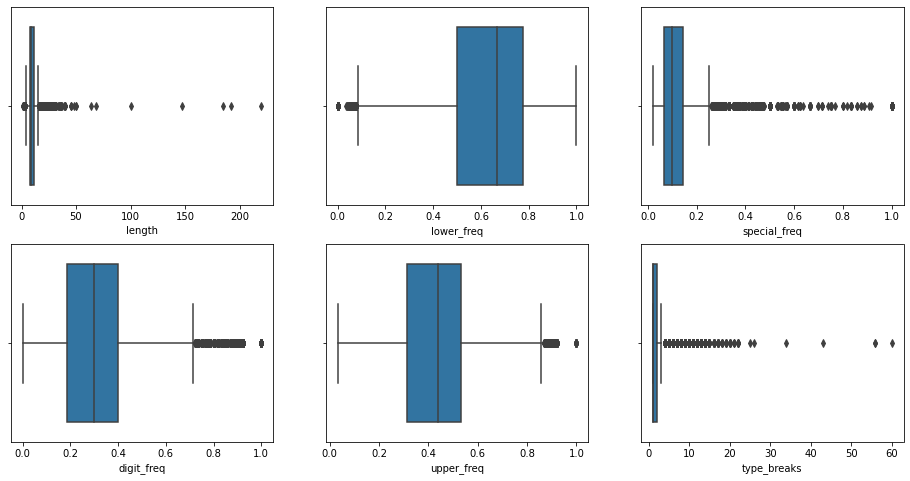

In [ ]:
plt.figure(figsize = (16,8))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax1 = sns.boxplot(x = 'length', data = df)

ax2 = plt.subplot2grid((2, 3), (0, 1))
ax2 = sns.boxplot(x = 'lower_freq', data = df)

ax3 = plt.subplot2grid((2, 3), (1, 0))
ax3 = sns.boxplot(x = 'digit_freq', data = df)

ax4 = plt.subplot2grid((2, 3), (1, 1))
ax4 = sns.boxplot(x = 'upper_freq', data = df[df['upper_freq'] > 0])

ax5 = plt.subplot2grid((2, 3), (0, 2))
ax5 = sns.boxplot(x = 'special_freq', data = df[df['special_freq'] > 0])

ax6 = plt.subplot2grid((2, 3), (1, 2))
ax6 = sns.boxplot(x = 'type_breaks', data = df[df['type_breaks'] > 0])

### Групповая статистика

In [ ]:
from IPython.display import display

cols = ['length', 'lower_freq', 'upper_freq', 'digit_freq', 'special_freq']

for i in cols:
    print(i)
    display(df[df[i] > 0].groupby('strength')[i].agg(['max', 'min', 'mean', 'median', pd.Series.mode]))

length


,max,min,mean,median,mode
strength,,,,,
0,7,1,6.549269,7.0,7
1,13,6,9.618843,9.0,9
2,220,11,15.932292,16.0,16


lower_freq


,max,min,mean,median,mode
strength,,,,,
0,1.000000,0.142857,0.726137,0.714286,0.714286
1,0.923077,0.076923,0.642889,0.666667,0.666667
2,0.933333,0.035714,0.423771,0.400000,0.375000


upper_freq


,max,min,mean,median,mode
strength,,,,,
0,1.000000,0.142857,0.644502,0.714286,0.666667
1,0.923077,0.076923,0.479718,0.500000,0.111111
2,0.904762,0.033333,0.398182,0.437500,0.500000


digit_freq


,max,min,mean,median,mode
strength,,,,,
0,1.000000,0.142857,0.279786,0.285714,0.285714
1,0.923077,0.076923,0.362775,0.333333,0.333333
2,0.916667,0.005208,0.196351,0.187500,0.125000


special_freq


,max,min,mean,median,mode
strength,,,,,
0,1.000000,0.142857,0.216509,0.142857,0.142857
1,0.916667,0.076923,0.158254,0.111111,0.111111
2,0.740741,0.020000,0.103311,0.071429,0.071429


### Количественная статистика

[]

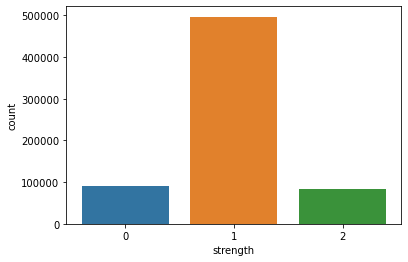

In [ ]:
sns.countplot(x = 'strength', data = df)
plt.plot()

[]

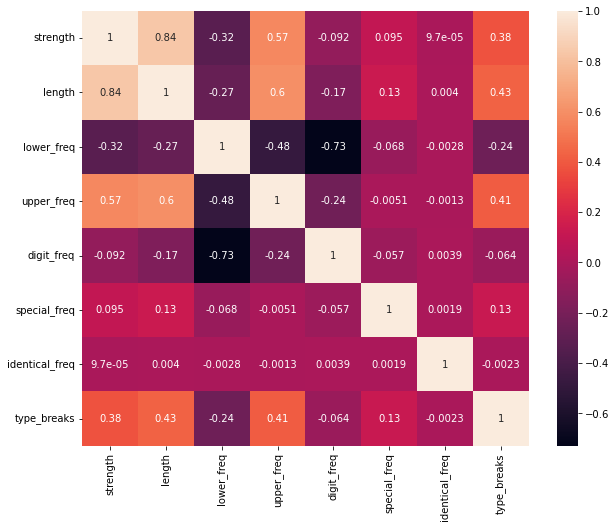

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot = True)
plt.plot()

False    669622
True         17
Name: identical_freq, dtype: int64 





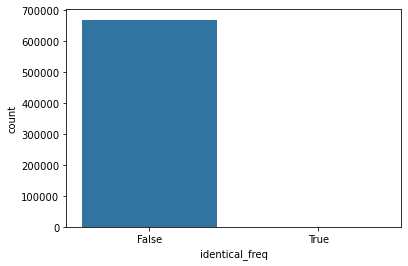

In [ ]:
sns.countplot(x = 'identical_freq', data = df)
plt.plot()

print(df['identical_freq'].value_counts(),'\n\n\n')

In [ ]:
df = df.drop(['identical_freq'], axis=1)

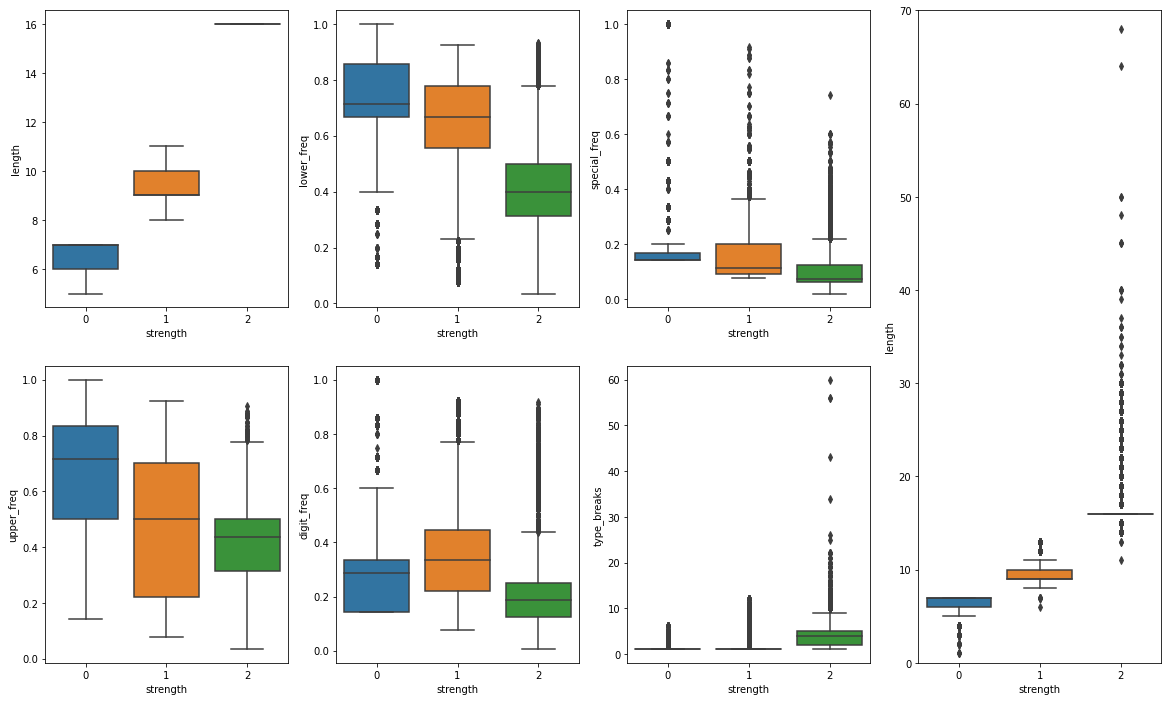

In [ ]:
plt.figure(figsize = (20,12))
ax1 = plt.subplot2grid((2, 4), (0, 0))
ax1 = sns.boxplot(x = df['strength'], y = df['length'], showfliers = False)   # showfliers = False doesn't plot outliers, too messy to infer anything so switched off.

ax2 = plt.subplot2grid((2, 4), (0, 1))
ax2 = sns.boxplot(x = 'strength', y = 'lower_freq', data = df[df['lower_freq'] > 0])

ax3 = plt.subplot2grid((2, 4), (1, 0))
ax3 = sns.boxplot(x = 'strength', y = 'upper_freq', data = df[df['upper_freq'] > 0])

ax4 = plt.subplot2grid((2, 4), (1, 1))
ax4 = sns.boxplot(x = 'strength', y = 'digit_freq', data = df[df['digit_freq'] > 0])

ax5 = plt.subplot2grid((2, 4), (0, 2))
ax5 = sns.boxplot(x = 'strength', y = 'special_freq', data = df[df['special_freq'] > 0])

ax6 = plt.subplot2grid((2, 4), (1, 2))
ax6 = sns.boxplot(x = 'strength', y = 'type_breaks', data = df[df['type_breaks'] > 0])

ax7 = plt.subplot2grid((2, 4), (0, 3), rowspan = 2)
ax7 = sns.boxplot(x = df['strength'], y = df['length'])
ax7 = plt.ylim(0,70)

## Преобразование данных

In [5]:
df = df.dropna()
# df["strength"] = df["strength"].map({0: "Weak", 1: "Medium", 2: "Strong"})
df['password'] = df['password'].astype(str).str.strip()

In [ ]:
from sklearn.utils import resample

df_w = df[df.strength==0]
df_m = df[df.strength==1]
df_s = df[df.strength==2]
df_s
df_m_sample = resample(df_m,
               replace=False,
               n_samples=min(len(df_w), len(df_s)),
               random_state=1)
  
df = pd.concat([df_w, df_m_sample, df_s])

In [ ]:
df.shape

(255975, 8)

In [ ]:
# df.to_csv (r'data_2.csv', index= False)

In [6]:
class_encoder = LabelEncoder()
df['strength'] = class_encoder.fit_transform(df['strength'])

In [7]:
X = df['password']
y = df['strength']
n_classes = y.nunique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Подготовка к построению моделей

In [8]:
class Vocab:
    def __init__(self, data):
        self.max_seq_len = data.str.len().max()
        
        tokens = set()
        for item in data:
            tokens.update(item)
            
        tokens = list(tokens)
        tokens.insert(0, "<PAD>")
        self.idx_to_token = dict(enumerate(tokens))
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

In [9]:
class PasswordsDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, password):
        password_t = torch.zeros(self.vocab.max_seq_len).type(torch.long)
        for i, token in enumerate(password):
            password_t[i] = self.vocab.token_to_idx[token]
        
        return password_t

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), self.y.iloc[idx]

In [35]:
def hard_training(model, criterion, optimizer, n_epochs=11):
    for epoch in range(n_epochs):
        epoch_loss = 0
        y_pred = torch.empty(0)
        y_true = torch.empty(0)
        for X_batch, y_batch in train_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.type(torch.long))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            with torch.no_grad():
                y_true = torch.cat((y_true, y_batch))
                y_pred = torch.cat((y_pred, predictions.argmax(dim=1).cpu().detach()))
        trin_acc = accuracy_score(y_true, y_pred).item()
        
        with torch.no_grad():
            val_loss = 0
            y_pred = torch.empty(0)
            y_true = torch.empty(0)
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch.type(torch.long)).item()
                y_true = torch.cat((y_true, y_batch))
                y_pred = torch.cat((y_pred, predictions.argmax(dim=1).cpu().detach()))
                val_loss += loss
            val_acc = accuracy_score(y_true, y_pred).item()
            if epoch % 1 == 0:
                print(f'#{epoch} Training loss: {epoch_loss / len(train_loader):.4f}\
 training_acc: {trin_acc:.4f} val_loss: {val_loss / len(test_loader):.4f} val_acc: {val_acc:.4f}')


def GloP_boB(model):
    y_pred = torch.empty(0)
    y_ = torch.empty(0)

    for X_batch, y_batch in test_loader:

        predictions = model(X_batch).argmax(dim=1).cpu().detach()
        y_pred = torch.cat((y_pred, predictions))
        y_ = torch.cat((y_, y_batch))

    print(classification_report(y_, y_pred, zero_division=0))

In [11]:
vocab = Vocab(X)
train_dataset = PasswordsDataset(X_train, y_train, vocab)
test_dataset = PasswordsDataset(X_test, y_test, vocab)

In [ ]:
print(train_dataset.vectorize('ok>bdk'))

tensor([166,  94,  95,  54,  69,  94,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [12]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Модель - CNN

In [16]:
class CNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.l1 = nn.Sequential(
            nn.Conv1d(embedding_dim, 64, kernel_size=5),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(108*64, 1024),
            nn.ReLU(),
            
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, 18),
            nn.Softmax(dim=1),
        )

    def forward(self, x, training=False):
        x = self.embedding(x).transpose(1,2)
        x = self.l1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [17]:
model = CNN(num_embeddings=vocab.vocab_len, embedding_dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
%%time

hard_training(model, criterion, optimizer)

train:   0%|          | 0/1600 [00:00<?, ?it/s]

#0 Training loss: 1.9919 training_acc: 0.9898 val_loss: 1.9823 val_acc: 0.9993


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#1 Training loss: 1.9824 training_acc: 0.9991 val_loss: 1.9829 val_acc: 0.9987


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#2 Training loss: 1.9825 training_acc: 0.9990 val_loss: 1.9821 val_acc: 0.9995


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#3 Training loss: 1.9823 training_acc: 0.9993 val_loss: 1.9821 val_acc: 0.9994


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#4 Training loss: 1.9822 training_acc: 0.9994 val_loss: 1.9820 val_acc: 0.9996


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#5 Training loss: 1.9821 training_acc: 0.9994 val_loss: 1.9820 val_acc: 0.9996


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#6 Training loss: 1.9822 training_acc: 0.9994 val_loss: 1.9819 val_acc: 0.9996


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#7 Training loss: 1.9819 training_acc: 0.9997 val_loss: 1.9819 val_acc: 0.9996


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#8 Training loss: 1.9818 training_acc: 0.9998 val_loss: 1.9819 val_acc: 0.9997


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#9 Training loss: 1.9823 training_acc: 0.9993 val_loss: 1.9819 val_acc: 0.9996


train:   0%|          | 0/1600 [00:00<?, ?it/s]

#10 Training loss: 1.9818 training_acc: 0.9998 val_loss: 1.9819 val_acc: 0.9997
CPU times: user 2h 4min 53s, sys: 9min 43s, total: 2h 14min 36s
Wall time: 2h 15min 54s


In [ ]:
GloP_boB(model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18009
         1.0       1.00      1.00      1.00     16557
         2.0       1.00      1.00      1.00     16629

    accuracy                           1.00     51195
   macro avg       1.00      1.00      1.00     51195
weighted avg       1.00      1.00      1.00     51195



In [ ]:
def test_password(passowrd):
    x = train_dataset.vectorize(passowrd).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    print(class_encoder.inverse_transform(predictions))

In [ ]:
for password in ("ok>bdk", "12kjl!", "password", "123123123", "abcabcabcabc", '!@GDS9asf!@(ds092', "juanpaganini588@gmail.com"):
    test_password(password)

[0]
[0]
[1]
[1]
[1]
[2]
[2]


## Модель - RNN

In [36]:
class RNN(nn.Module):
    def __init__(
            self,
            rnn_cls,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.hx = None
        self.rnn = rnn_cls(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x, hx = self.rnn(x, self.hx)
        x = torch.flatten(x, 1)
        
        return self.classifier(x)

In [37]:
torch.manual_seed(0)

model = RNN(
    rnn_cls=nn.RNN,
    num_embeddings=vocab.vocab_len,
    embedding_dim=100,
    rnn_hidden_size=64,
    vector_size=vocab.max_seq_len,
    num_classes=n_classes,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [38]:
%%time

hard_training(model, criterion, optimizer)

#0 Training loss: 0.0227 training_acc: 0.9919 val_loss: 0.0025 val_acc: 0.9998
#1 Training loss: 0.0022 training_acc: 0.9995 val_loss: 0.0009 val_acc: 0.9999
#2 Training loss: 0.0003 training_acc: 1.0000 val_loss: 0.0008 val_acc: 0.9999
#3 Training loss: 0.0234 training_acc: 0.9986 val_loss: 0.0068 val_acc: 0.9996
#4 Training loss: 0.0008 training_acc: 0.9999 val_loss: 0.0118 val_acc: 0.9997
#5 Training loss: 0.0024 training_acc: 0.9998 val_loss: 0.0050 val_acc: 0.9996
#6 Training loss: 0.0010 training_acc: 0.9998 val_loss: 0.0044 val_acc: 0.9999
#7 Training loss: 0.0013 training_acc: 0.9998 val_loss: 0.0042 val_acc: 0.9999
#8 Training loss: 0.0980 training_acc: 0.9980 val_loss: 0.0067 val_acc: 0.9998
#9 Training loss: 0.0010 training_acc: 0.9999 val_loss: 0.0036 val_acc: 0.9999
#10 Training loss: 0.0009 training_acc: 1.0000 val_loss: 0.0030 val_acc: 0.9999
CPU times: user 1h 16min 4s, sys: 6.18 s, total: 1h 16min 10s
Wall time: 1h 16min 33s


In [39]:
GloP_boB(model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18009
         1.0       1.00      1.00      1.00     16557
         2.0       1.00      1.00      1.00     16629

    accuracy                           1.00     51195
   macro avg       1.00      1.00      1.00     51195
weighted avg       1.00      1.00      1.00     51195



In [40]:
def test_password(passowrd):
    x = train_dataset.vectorize(passowrd).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    print(class_encoder.inverse_transform(predictions))

In [41]:
for password in ("ok>bdk", "12kjl!", "password", "123123123", "abcabcabcabc", '!@GDS9asf!@(ds092', "juanpaganini588@gmail.com"):
    test_password(password)

[0]
[0]
[1]
[1]
[1]
[2]
[2]


## Модель - LSTM

In [42]:
torch.manual_seed(0)

model = RNN(
    rnn_cls=nn.LSTM,
    num_embeddings=vocab.vocab_len,
    embedding_dim=100,
    rnn_hidden_size=64,
    vector_size=vocab.max_seq_len,
    num_classes=n_classes,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [43]:
%%time

hard_training(model, criterion, optimizer)

#0 Training loss: 0.0207 training_acc: 0.9919 val_loss: 0.0007 val_acc: 0.9999
#1 Training loss: 0.0007 training_acc: 0.9999 val_loss: 0.0047 val_acc: 0.9997
#2 Training loss: 0.0008 training_acc: 0.9999 val_loss: 0.0020 val_acc: 0.9997
#3 Training loss: 0.0006 training_acc: 0.9999 val_loss: 0.0017 val_acc: 0.9999
#4 Training loss: 0.0010 training_acc: 0.9999 val_loss: 0.0033 val_acc: 0.9998
#5 Training loss: 0.0005 training_acc: 0.9999 val_loss: 0.0039 val_acc: 0.9999
#6 Training loss: 0.0006 training_acc: 0.9999 val_loss: 0.0015 val_acc: 0.9999
#7 Training loss: 0.0008 training_acc: 0.9999 val_loss: 0.0014 val_acc: 0.9999
#8 Training loss: 0.0001 training_acc: 1.0000 val_loss: 0.0021 val_acc: 0.9999
#9 Training loss: 0.0001 training_acc: 1.0000 val_loss: 0.0016 val_acc: 0.9999
#10 Training loss: 0.0006 training_acc: 0.9999 val_loss: 0.0021 val_acc: 0.9999
CPU times: user 1h 52min 10s, sys: 24min 6s, total: 2h 16min 16s
Wall time: 2h 16min 48s


In [44]:
GloP_boB(model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18009
         1.0       1.00      1.00      1.00     16557
         2.0       1.00      1.00      1.00     16629

    accuracy                           1.00     51195
   macro avg       1.00      1.00      1.00     51195
weighted avg       1.00      1.00      1.00     51195



In [45]:
def test_password(passowrd):
    x = train_dataset.vectorize(passowrd).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    print(class_encoder.inverse_transform(predictions))

In [46]:
for password in ("ok>bdk", "12kjl!", "password", "123123123", "abcabcabcabc", '!@GDS9asf!@(ds092', "juanpaganini588@gmail.com"):
    test_password(password)

[0]
[0]
[1]
[1]
[1]
[2]
[2]


## Модель - GRU

In [47]:
torch.manual_seed(0)

model = RNN(
    rnn_cls=nn.GRU,
    num_embeddings=vocab.vocab_len,
    embedding_dim=100,
    rnn_hidden_size=64,
    vector_size=vocab.max_seq_len,
    num_classes=n_classes,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [48]:
%%time

hard_training(model, criterion, optimizer)

#0 Training loss: 0.0229 training_acc: 0.9915 val_loss: 0.0014 val_acc: 0.9997
#1 Training loss: 0.0005 training_acc: 0.9999 val_loss: 0.0007 val_acc: 0.9999
#2 Training loss: 0.0020 training_acc: 0.9996 val_loss: 0.0031 val_acc: 0.9996
#3 Training loss: 0.0009 training_acc: 0.9999 val_loss: 0.0023 val_acc: 0.9999
#4 Training loss: 0.0012 training_acc: 0.9998 val_loss: 0.0044 val_acc: 0.9998
#5 Training loss: 0.0014 training_acc: 0.9999 val_loss: 0.0028 val_acc: 0.9999
#6 Training loss: 0.0013 training_acc: 0.9999 val_loss: 0.0021 val_acc: 0.9999
#7 Training loss: 0.0007 training_acc: 0.9999 val_loss: 0.0034 val_acc: 0.9999
#8 Training loss: 0.0004 training_acc: 0.9999 val_loss: 0.0040 val_acc: 0.9999
#9 Training loss: 0.0010 training_acc: 0.9999 val_loss: 0.0066 val_acc: 0.9999
#10 Training loss: 0.0010 training_acc: 0.9999 val_loss: 0.0030 val_acc: 1.0000
CPU times: user 2h 8min 15s, sys: 10 s, total: 2h 8min 25s
Wall time: 2h 8min 49s


In [49]:
GloP_boB(model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18009
         1.0       1.00      1.00      1.00     16557
         2.0       1.00      1.00      1.00     16629

    accuracy                           1.00     51195
   macro avg       1.00      1.00      1.00     51195
weighted avg       1.00      1.00      1.00     51195



In [50]:
def test_password(passowrd):
    x = train_dataset.vectorize(passowrd).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    print(class_encoder.inverse_transform(predictions))

In [51]:
for password in ("ok>bdk", "12kjl!", "password", "123123123", "abcabcabcabc", '!@GDS9asf!@(ds092', "juanpaganini588@gmail.com"):
    test_password(password)

[0]
[0]
[1]
[1]
[1]
[2]
[2]


## Результаты

In [54]:
result_df = pd.DataFrame(data=[['100%', '135.9'], ['100%', '76.5'], ['100%', '136.8'], ['100%', '128.8']], index=["CNN", 'RNN', 'LSTM', 'GRU'], columns=['Точность', 'Время(мин)'])
result_df

,Точность,Время(мин)
CNN,100%,135.9
RNN,100%,76.5
LSTM,100%,136.8
GRU,100%,128.8


In [58]:
result_df.to_csv('results.csv', encoding='utf-8')